<a href="https://colab.research.google.com/github/DiogoLepri/ASD2_Project/blob/main/ASD-DiagNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ASD2_Project/

/content/drive/MyDrive/ASD2_Project


In [3]:
!pip install pandas numpy matplotlib scikit-learn torch pyprind scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [4]:
#options: cc200, dosenbach160, aal
p_ROI = "cc200"
p_fold = 10
p_center = "Stanford"
p_mode = "whole"
p_augmentation = True
p_Method = "ASD-DiagNet"

In [5]:
parameter_list = [p_ROI,p_fold,p_center,p_mode,p_augmentation,p_Method]
print("*****List of patameters****")
print("ROI atlas: ",p_ROI)
print("per Center or whole: ",p_mode)
if p_mode == 'percenter':
    print("Center's name: ",p_center)
print("Method's name: ",p_Method)
if p_Method == "ASD-DiagNet":
    print("Augmentation: ",p_augmentation)


*****List of patameters****
ROI atlas:  cc200
per Center or whole:  whole
Method's name:  ASD-DiagNet
Augmentation:  True


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
from sklearn.impute import SimpleImputer
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import pyprind
import sys
import pickle
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold, StratifiedKFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn import tree
import functools
import numpy.ma as ma # for masked arrays
import pyprind
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

## Importing the data

In [7]:
def get_key(filename):
    f_split = filename.split('_')
    if f_split[3] == 'rois':
        key = '_'.join(f_split[0:3])
    else:
        key = '_'.join(f_split[0:2])
    return key

Correlation Matrix:
          FIQ       PIQ       VIQ
FIQ  1.000000  0.837772  0.756112
PIQ  0.837772  1.000000  0.902055
VIQ  0.756112  0.902055  1.000000


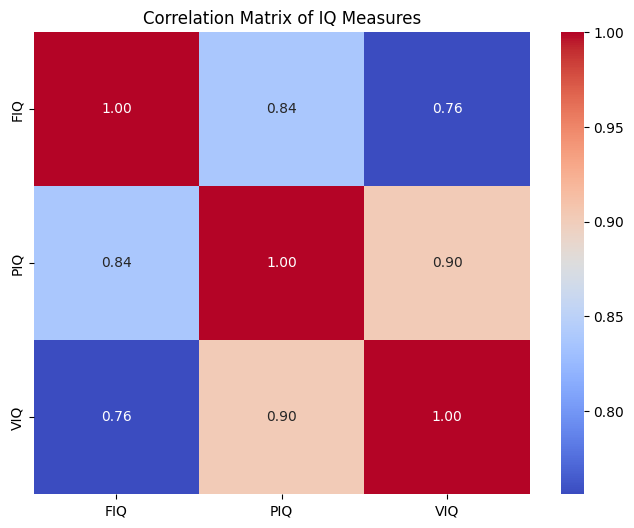

In [ ]:
df_labels = pd.read_csv('/content/drive/MyDrive/ASD2_Project/Phenotypic_V1_0b_preprocessed1.csv')
iq_columns = ['FIQ', 'PIQ', 'VIQ']


for col in iq_columns:
    df_labels[col] = pd.to_numeric(df_labels[col], errors='coerce')


df_iq = df_labels[iq_columns].dropna()


corr_matrix = df_iq.corr()


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of IQ Measures")
plt.show()

In [8]:
data_main_path = f'/content/drive/MyDrive/ASD2_Project/Outputs/cpac/filt_global/rois_{p_ROI}'
flist = os.listdir(data_main_path)
print(len(flist))

for f in range(len(flist)):
    flist[f] = get_key(flist[f])


df_labels = pd.read_csv('/content/drive/MyDrive/ASD2_Project/Phenotypic_V1_0b_preprocessed1.csv')
df_labels.DX_GROUP = df_labels.DX_GROUP.map({1: 1, 2: 0})
print(len(df_labels))

labels = {}
for i, row in df_labels.iterrows():
    file_id = row['FILE_ID']
    y_label = row['DX_GROUP']
    if file_id == 'no_filename':
        continue
    assert(file_id not in labels)
    labels[file_id] = y_label

#new age
df_labels['AGE_AT_SCAN'] = df_labels['AGE_AT_SCAN'].astype(np.float32)
ages = df_labels['AGE_AT_SCAN']
ages_norm = ((ages - ages.mean()) / ages.std()).round(1)

#IQS
iq_columns = ['FIQ', 'PIQ', 'VIQ']


for col in iq_columns:
    df_labels.loc[df_labels[col] == -9999, col] = np.nan


imputer = IterativeImputer(random_state=0)
df_labels[iq_columns] = imputer.fit_transform(df_labels[iq_columns])


phen_dict = {}
for i, row in df_labels.iterrows():
    file_id = row['FILE_ID']
    if file_id == 'no_filename':
        continue
    phen_dict[file_id] = [ages_norm.iloc[i], row['FIQ'], row['VIQ'], row['PIQ']]
#phen_dict[file_id] = [ages_norm.iloc[i], row['FIQ'], row['VIQ'], row['PIQ']]

884
1112


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [9]:
print(phen_dict)

{'Pitt_0050003': [0.9, 124.0, 128.0, 115.0], 'Pitt_0050004': [0.3, 113.0, 108.0, 117.0], 'Pitt_0050005': [-0.4, 119.0, 117.0, 118.0], 'Pitt_0050006': [-0.5, 109.0, 99.0, 119.0], 'Pitt_0050007': [0.1, 110.0, 106.0, 112.0], 'Pitt_0050008': [1.9, 123.0, 123.0, 114.0], 'Pitt_0050009': [2.1, 126.0, 118.0, 128.0], 'Pitt_0050010': [2.3, 81.0, 81.0, 93.0], 'Pitt_0050011': [-0.0, 111.0, 101.0, 120.0], 'Pitt_0050012': [0.6, 128.0, 119.0, 128.0], 'Pitt_0050013': [-1.0, 86.0, 89.0, 87.0], 'Pitt_0050014': [-0.4, 96.0, 97.0, 96.0], 'Pitt_0050015': [-0.4, 99.0, 98.0, 99.0], 'Pitt_0050016': [0.6, 123.0, 120.0, 119.0], 'Pitt_0050017': [0.7, 87.0, 91.0, 86.0], 'Pitt_0050019': [1.3, 100.0, 89.0, 111.0], 'Pitt_0050020': [0.5, 100.0, 120.0, 83.0], 'Pitt_0050022': [-0.0, 119.0, 110.0, 110.0], 'Pitt_0050023': [-0.5, 97.0, 83.0, 111.0], 'Pitt_0050024': [0.7, 127.0, 121.0, 126.0], 'Pitt_0050025': [1.8, 131.0, 132.0, 123.0], 'Pitt_0050026': [-0.1, 87.0, 90.0, 88.0], 'Pitt_0050027': [-0.6, 98.0, 98.0, 98.0], 'Pi

### Helper functions for computing correlations

In [12]:
def get_label(filename):
    assert (filename in labels)
    return labels[filename]


def get_corr_data(filename):
    #print(filename)
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')

    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        mask = np.invert(np.tri(corr.shape[0], k=-1, dtype=bool))
        m = ma.masked_where(mask == 1, mask)
        return ma.masked_where(m, corr).compressed()

def get_corr_matrix(filename):
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')
    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        return corr

def confusion(g_turth,predictions):
    tn, fp, fn, tp = confusion_matrix(g_turth,predictions).ravel()
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    sensitivity = (tp)/(tp+fn)
    specificty = (tn)/(tn+fp)
    return accuracy,sensitivity,specificty

def get_regs(samplesnames,regnum):
    datas = []
    for sn in samplesnames:
        datas.append(all_corr[sn][0])
    datas = np.array(datas)
    avg=[]
    for ie in range(datas.shape[1]):
        avg.append(np.mean(datas[:,ie]))
    avg=np.array(avg)
    highs=avg.argsort()[-regnum:][::-1]
    lows=avg.argsort()[:regnum][::-1]
    regions=np.concatenate((highs,lows),axis=0)
    return regions


## Helper fnuctions for computing correlations (Step A)

In [13]:
if not os.path.exists('./correlations_file'+p_ROI+'.pkl'):
    pbar=pyprind.ProgBar(len(flist))
    all_corr = {}
    for f in flist:

        lab = get_label(f)
        all_corr[f] = (get_corr_data(f), lab)
        pbar.update()

    print('Corr-computations finished')

    pickle.dump(all_corr, open('./correlations_file'+p_ROI+'.pkl', 'wb'))
    print('Saving to file finished')

else:
    all_corr = pickle.load(open('./correlations_file'+p_ROI+'.pkl', 'rb'))

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:12


Corr-computations finished
Saving to file finished


## Computing eigenvalues and eigenvector

In [ ]:
if p_Method=="ASD-DiagNet":
    eig_data = {}
    pbar = pyprind.ProgBar(len(flist))
    for f in flist:
        d = get_corr_matrix(f)
        eig_vals, eig_vecs = np.linalg.eig(d)

        for ev in eig_vecs.T:
            np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

        sum_eigvals = np.sum(np.abs(eig_vals))
        # Make a list of (eigenvalue, eigenvector, norm_eigval) tuples
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i], np.abs(eig_vals[i])/sum_eigvals)
                     for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eig_pairs.sort(key=lambda x: x[0], reverse=True)

        eig_data[f] = {'eigvals':np.array([ep[0] for ep in eig_pairs]),
                       'norm-eigvals':np.array([ep[2] for ep in eig_pairs]),
                       'eigvecs':[ep[1] for ep in eig_pairs]}
        pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:44


## Calculating Eros similarity

In [ ]:
def norm_weights(sub_flist):
    num_dim = len(eig_data[flist[0]]['eigvals'])
    norm_weights = np.zeros(shape=num_dim)
    for f in sub_flist:
        norm_weights += eig_data[f]['norm-eigvals']
    return norm_weights

def cal_similarity(d1, d2, weights, lim=None):
    res = 0.0
    if lim is None:
        weights_arr = weights.copy()
    else:
        weights_arr = weights[:lim].copy()
        weights_arr /= np.sum(weights_arr)
    for i,w in enumerate(weights_arr):
        res += w*np.inner(d1[i], d2[i])
    return res

## Defining dataset class (Step B)

In [ ]:
class CC200Dataset(Dataset):
    def __init__(self, pkl_filename=None, data=None, samples_list=None,
                 phenotype_data=None,#new
                 augmentation=False, aug_factor=1, num_neighbs=5,
                 eig_data=None, similarity_fn=None, verbose=False, regs=None):
        self.regs = regs
        self.phenotype_data = phenotype_data  #new
        if pkl_filename is not None:
            if verbose:
                print('Loading ..!', end=' ')
            self.data = pickle.load(open(pkl_filename, 'rb'))
        elif data is not None:
            self.data = data.copy()
        else:
            sys.stderr.write('Either PKL file or data is needed!')
            return

        #if verbose:
        #    print ('Preprocess..!', end='  ')
        if samples_list is None:
            self.flist = [f for f in self.data]
        else:
            self.flist = [f for f in samples_list]
        self.labels = np.array([self.data[f][1] for f in self.flist])

        current_flist = np.array(self.flist.copy())
        current_lab0_flist = current_flist[self.labels == 0]
        current_lab1_flist = current_flist[self.labels == 1]
        #if verbose:
        #    print(' Num Positive : ', len(current_lab1_flist), end=' ')
        #    print(' Num Negative : ', len(current_lab0_flist), end=' ')


        if augmentation:
            self.num_data = aug_factor * len(self.flist)
            self.neighbors = {}
            pbar = pyprind.ProgBar(len(self.flist))
            weights = norm_weights(samples_list)#??
            for f in self.flist:
                label = self.data[f][1]
                candidates = (set(current_lab0_flist) if label == 0 else set(current_lab1_flist))
                candidates.remove(f)
                eig_f = eig_data[f]['eigvecs']
                sim_list = []
                for cand in candidates:
                    eig_cand = eig_data[cand]['eigvecs']
                    sim = similarity_fn(eig_f, eig_cand, weights)
                    sim_list.append((sim, cand))
                sim_list.sort(key=lambda x: x[0], reverse=True)
                self.neighbors[f] = [item[1] for item in sim_list[:num_neighbs]]#list(candidates)#[item[1] for item in sim_list[:num_neighbs]]

        else:
            self.num_data = len(self.flist)

    def __getitem__(self, index):
        if index < len(self.flist):
            fname = self.flist[index]
            data = self.data[fname][0].copy() #get_corr_data(fname, mode=cal_mode)
            data = data[self.regs].copy()
            label = (self.labels[index],)

            #new
            if self.phenotype_data is not None:
                # Retrieve phenotype data using the file identifier as key
                pheno_vals = self.phenotype_data[fname]
                return torch.FloatTensor(data), torch.FloatTensor(pheno_vals), torch.FloatTensor(label)
            else:
                return torch.FloatTensor(data), torch.FloatTensor(label)

        else:
            f1 = self.flist[index % len(self.flist)]
            d1, y1 = self.data[f1][0], self.data[f1][1]
            d1=d1[self.regs]
            if len(self.neighbors[f1]) > 0:#new
                f2 = np.random.choice(self.neighbors[f1])
            else:
                f2 = f1  # fallback to self if no neighbors exist
            d2, y2 = self.data[f2][0], self.data[f2][1]
            d2 = d2[self.regs]
            assert y1 == y2
            r = np.random.uniform(low=0, high=1)
            label = (y1,)
            data = r * d1 + (1 - r) * d2

            #new check---------
            if self.phenotype_data is not None:
                # Use phenotype from the first sample for the augmented data
                pheno_vals = self.phenotype_data[f1]
                return torch.FloatTensor(data), torch.FloatTensor(pheno_vals), torch.FloatTensor(label)
            else:
                return torch.FloatTensor(data), torch.FloatTensor(label)

    def __len__(self):
        return self.num_data

## Definig data loader function

In [ ]:
def get_loader(pkl_filename=None, data=None, samples_list=None,
               batch_size=64,
               num_workers=1, mode='train',
               *, augmentation=False, aug_factor=1, num_neighbs=5,
               eig_data=None, similarity_fn=None, verbose=False, regions=None,
               phenotype_data=None):  #new pheno data
    """Build and return data loader."""
    if mode == 'train':
        shuffle = True
    else:
        shuffle = False
        augmentation = False

    dataset = CC200Dataset(pkl_filename=pkl_filename, data=data, samples_list=samples_list,
                           augmentation=augmentation, aug_factor=aug_factor,
                           eig_data=eig_data, similarity_fn=similarity_fn, verbose=verbose, regs=regions,
                           phenotype_data=phenotype_data)  #new pheno data

    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers)

    return data_loader

## Defining Autoencoder class (Step C & D)

In [ ]:
class MTAutoEncoder(nn.Module):
    def __init__(self, num_inputs=990,
                 num_latent=200, tied=True,
                 num_classes=2, use_dropout=False):
        super(MTAutoEncoder, self).__init__()
        self.tied = tied
        self.num_latent = num_latent

        self.fc_encoder = nn.Linear(num_inputs, num_latent)

        if not tied:
            self.fc_decoder = nn.Linear(num_latent, num_inputs)


        if use_dropout:
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(self.num_latent + 4, 1)#new +1,1
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(self.num_latent + 4, 1)#new +1,1
            )

    def forward(self, x, pheno_data=None, eval_classifier=False):
      x = self.fc_encoder(x)
      x = torch.tanh(x)
      #print(pheno_data)
      #print("=============")
      if eval_classifier:
          if pheno_data is None:
              raise ValueError("Classifier mode requires pheno values input")

          pheno_data = pheno_data.to(x.device)
          combined = torch.cat((x, pheno_data), dim=1)
          # Print the classifier input vector shape only once per cell
          if not hasattr(self, '_printed_vector_size'):
              print("Classifier input vector shape (with pheno data):", combined.shape)
              self._printed_vector_size = True
          x_logit = self.classifier(combined)
      else:
          x_logit = None

      if self.tied:
          x = F.linear(x, self.fc_encoder.weight.t())
      else:
          x = self.fc_decoder(x)

      return x, x_logit


mtae = MTAutoEncoder()
mtae


MTAutoEncoder(
  (fc_encoder): Linear(in_features=990, out_features=200, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=204, out_features=1, bias=True)
  )
)

## Defining training and testing functions

In [ ]:
def train(model, epoch, train_loader, p_bernoulli=None, mode='both', lam_factor=1.0):
    model.train()
    train_losses = []

    for i, (images, pheno_data, batch_y) in enumerate(train_loader):#new before batch_x now = images
        if len(images) != batch_size:
            continue

        if p_bernoulli is not None:
            if i == 0:
                p_tensor = torch.ones_like(images).to(device) * p_bernoulli
            rand_bernoulli = torch.bernoulli(p_tensor).to(device)

        images = images.to(device)
        pheno_data = pheno_data.to(device)#new
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        if mode in ['both', 'ae']:
            if p_bernoulli is not None:
                rec_noisy, _ = model(images * rand_bernoulli, pheno_data, False)#new
                loss_ae = criterion_ae(rec_noisy, images) / len(images)
            else:
                rec, _ = model(images, pheno_data, False)#new
                loss_ae = criterion_ae(rec, images) / len(images)

        if mode in ['both', 'clf']:
            rec_clean, logits = model(images, pheno_data, True)#new
            loss_clf = criterion_clf(logits, batch_y)

        if mode == 'both':
            loss_total = loss_ae + lam_factor * loss_clf
            train_losses.append([loss_ae.detach().cpu().numpy(), loss_clf.detach().cpu().numpy()])
        elif mode == 'ae':
            loss_total = loss_ae
            train_losses.append([loss_ae.detach().cpu().numpy(), 0.0])
        elif mode == 'clf':
            loss_total = loss_clf
            train_losses.append([0.0, loss_clf.detach().cpu().numpy()])

        loss_total.backward()
        optimizer.step()

    return train_losses

def test(model, criterion, test_loader,
         eval_classifier=False, num_batch=None):
    test_loss, n_test, correct = 0.0, 0, 0
    all_predss = []
    if eval_classifier:
        y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for i, (images, pheno_data, batch_y) in enumerate(test_loader, 1):#new
            if num_batch is not None and i >= num_batch:
                continue
            images = images.to(device)
            pheno_data_data = pheno_data.to(device)
            batch_y = batch_y.to(device)

            rec, logits = model(images, pheno_data, eval_classifier)
            test_loss += criterion(rec, images).detach().cpu().numpy()
            n_test += len(images)
            if eval_classifier:
                proba = torch.sigmoid(logits).detach().cpu().numpy()
                preds = np.ones_like(proba, dtype=np.int32)
                preds[proba < 0.5] = 0
                all_predss.extend(preds)
                y_arr = batch_y.cpu().numpy().astype(np.int32)
                correct += np.sum(preds == y_arr)
                y_true.extend(y_arr.tolist())
                y_pred.extend(proba.tolist())
        if eval_classifier:
            mlp_acc, mlp_sens, mlp_spef = confusion(y_true, all_predss)
    return mlp_acc, mlp_sens, mlp_spef



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
if p_Method == "ASD-DiagNet" and p_mode == "whole":
    num_corr = len(all_corr[flist[0]][0])
    print("num_corr:  ", num_corr)

    start = time.time()
    batch_size = 8
    learning_rate_ae, learning_rate_clf = 0.0001, 0.0001
    num_epochs = 25

    p_bernoulli = None
    augmentation = p_augmentation
    use_dropout = False

    aug_factor = 2
    num_neighbs = 5
    lim4sim = 2
    n_lat = int(num_corr / 4)
    print("Initial n_lat:", n_lat)
    start = time.time()

    print('p_bernoulli:', p_bernoulli)
    print('augmentation:', augmentation, 'aug_factor:', aug_factor,
          'num_neighbs:', num_neighbs, 'lim4sim:', lim4sim)
    print('use_dropout:', use_dropout, '\n')

    # Check if phenotypic data is available and optionally print a sample vector.
    if len(phen_dict) > 0:
        sample_key = list(phen_dict.keys())[0]
        pheno_vect = phen_dict[sample_key]

    sim_function = functools.partial(cal_similarity, lim=lim4sim)
    crossval_res_kol = []
    y_arr = np.array([get_label(f) for f in flist])
    flist = np.array(flist)

    # Optionally adjust folds based on phenotypic data (as in percenter code)
    if len(phen_dict) > 0:
        unique_labels, counts = np.unique(y_arr, return_counts=True)
        new_n_splits = min(p_fold, counts.min())
        if new_n_splits < 2:
            print("Skipping due to insufficient samples per class when using phenotypic data.")
            # You could exit or set new_n_splits = 2 if that makes sense.
        else:
            print(f"Using {new_n_splits}-fold cross-validation with phenotypic data for whole dataset.")
    else:
        new_n_splits = p_fold

    for rp in range(10):
        kf = StratifiedKFold(n_splits=new_n_splits, random_state=1, shuffle=True)
        np.random.shuffle(flist)
        y_arr = np.array([get_label(f) for f in flist])
        for kk, (train_index, test_index) in enumerate(kf.split(flist, y_arr)):
            train_samples, test_samples = flist[train_index], flist[test_index]
            verbose = (True if (kk == 0) else False)
            regions_inds = get_regs(train_samples, int(num_corr / 4))
            num_inpp = len(regions_inds)
            n_lat = int(num_inpp / 2)

            # Include phenotype_data in both train and test loaders.
            train_loader = get_loader(data=all_corr, samples_list=train_samples,
                                      batch_size=batch_size, mode='train',
                                      augmentation=augmentation, aug_factor=aug_factor,
                                      num_neighbs=num_neighbs, eig_data=eig_data,
                                      similarity_fn=sim_function, verbose=verbose,
                                      regions=regions_inds, phenotype_data=phen_dict)

            test_loader = get_loader(data=all_corr, samples_list=test_samples,
                                     batch_size=batch_size, mode='test',
                                     augmentation=False, verbose=verbose,
                                     regions=regions_inds, phenotype_data=phen_dict)

            model = MTAutoEncoder(tied=True, num_inputs=num_inpp,
                                  num_latent=n_lat, use_dropout=use_dropout)
            model.to(device)
            criterion_ae = nn.MSELoss(reduction='sum')
            criterion_clf = nn.BCEWithLogitsLoss()
            optimizer = optim.SGD([{'params': model.fc_encoder.parameters(), 'lr': learning_rate_ae},
                                   {'params': model.classifier.parameters(), 'lr': learning_rate_clf}],
                                  momentum=0.9)

            for epoch in range(1, num_epochs + 1):
                if epoch <= 20:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='both')
                else:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='clf')

            res_mlp = test(model, criterion_ae, test_loader, eval_classifier=True)
            crossval_res_kol.append(res_mlp)
        print("Averages over folds:")
        print(np.mean(np.array(crossval_res_kol), axis=0))
        finish = time.time()
        print("Elapsed time:", finish - start)


num_corr:   19900
Initial n_lat: 4975
p_bernoulli: None
augmentation: True aug_factor: 2 num_neighbs: 5 lim4sim: 2
use_dropout: False 

Using phenotypic data from key: Pitt_0050003
Using 10-fold cross-validation with phenotypic data for whole dataset.
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Fold result: (0.5, 1.0, 0.0)
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Fold result: (0.5, 0.0, 1.0)
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Fold result: (0.5, 0.0, 1.0)
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Fold result: (0.75, 1.0, 0.5)
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Fold result: (0.5, 1.0, 0.0)
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Fold result: (0.5, 0.0, 1.0)
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Fold result: (0.6666666666666666, 0.0, 1.0)
Classifier input vector shape (w

In [ ]:
p_ROI = "cc200"
p_fold = 5  # Use 5-fold for intra-site evaluation
p_center = "Stanford"
p_mode = "percenter"  # Change to "percenter" for intra-site evaluation
p_augmentation = True
p_Method = "ASD-DiagNet"

In [ ]:
if p_Method == "ASD-DiagNet" and p_mode == "percenter":
    num_corr = len(all_corr[flist[0]][0])

    if len(phen_dict) > 0:
        sample_key = list(phen_dict.keys())[0]
        pheno_vect = phen_dict[sample_key]

    flist = os.listdir(data_main_path)

    for f in range(len(flist)):
        flist[f] = get_key(flist[f])

    centers_dict = {}
    for f in flist:
        key = f.split('_')[0]

        if key not in centers_dict:
            centers_dict[key] = []
        centers_dict[key].append(f)

    flist = np.array(centers_dict[p_center])
    y_arr = np.array([get_label(f) for f in flist])

    # Determine the number of splits.
    if len(phen_dict) > 0:
        unique_labels, counts = np.unique(y_arr, return_counts=True)
        new_n_splits = min(p_fold, counts.min())
        if new_n_splits < 2:
            print(f"Skipping center {p_center} due to insufficient samples in one class.")
            # Optionally, exit or continue to the next center.
        else:
            print(f"Using {new_n_splits}-fold cross-validation for center {p_center}.")
    else:
        new_n_splits = p_fold
        print(f"Using {new_n_splits}-fold cross-validation for center {p_center}.")

    flist = np.array(centers_dict[p_center])

    start =time.time()
    #flist = np.array(sorted(os.listdir(data_main_path)))
    batch_size = 8
    learning_rate_ae, learning_rate_clf = 0.0001, 0.0001

    num_epochs = 25
    p_bernoulli = None
    augmentation = p_augmentation
    use_dropout = False

    aug_factor = 2
    num_neighbs = 5
    lim4sim = 2
    n_lat = int(num_corr / 4)

    print('p_bernoulli: ', p_bernoulli)
    print('augmentation: ', augmentation, 'aug_factor: ', aug_factor,
          'num_neighbs: ', num_neighbs, 'lim4sim: ', lim4sim)
    print('use_dropout: ', use_dropout, '\n')

    sim_function = functools.partial(cal_similarity, lim=lim4sim)
    all_rp_res = []
    y_arr = np.array([get_label(f) for f in flist])

    # Only continue if we have enough splits.
    if len(phen_dict) > 0 and new_n_splits < 2:
        pass
    else:
        for rp in range(10):
            print("========================")
            crossval_res_kol = []
            start_rp = time.time()
            kf = StratifiedKFold(n_splits=new_n_splits)
            for kk, (train_index, test_index) in enumerate(kf.split(flist, y_arr)):

                train_samples, test_samples = flist[train_index], flist[test_index]

                verbose = (True if (kk == 0) else False)

                regions_inds = get_regs(train_samples, int(num_corr/4))
                num_inpp = len(regions_inds)
                n_lat = int(num_inpp/2)
                num_inpp = len(regions_inds)
                if len(phen_dict) > 0:
                    train_loader = get_loader(data=all_corr, samples_list=train_samples,
                                              batch_size=batch_size, mode='train',
                                              augmentation=augmentation, aug_factor=aug_factor,
                                              num_neighbs=num_neighbs, eig_data=eig_data, similarity_fn=sim_function,
                                              verbose=verbose, regions=regions_inds, phenotype_data=phen_dict)

                    test_loader = get_loader(data=all_corr, samples_list=test_samples,
                                             batch_size=batch_size, mode='test', augmentation=False,
                                             verbose=verbose, regions=regions_inds, phenotype_data=phen_dict)
                else:
                    train_loader = get_loader(data=all_corr, samples_list=train_samples,
                                              batch_size=batch_size, mode='train',
                                              augmentation=augmentation, aug_factor=aug_factor,
                                              num_neighbs=num_neighbs, eig_data=eig_data, similarity_fn=sim_function,
                                              verbose=verbose, regions=regions_inds)

                    test_loader = get_loader(data=all_corr, samples_list=test_samples,
                                             batch_size=batch_size, mode='test', augmentation=False,
                                             verbose=verbose, regions=regions_inds)

                model = MTAutoEncoder(tied=True, num_inputs=num_inpp, num_latent=n_lat, use_dropout=use_dropout)
                model.to(device)
                criterion_ae = nn.MSELoss(reduction='sum')
                criterion_clf = nn.BCEWithLogitsLoss()
                optimizer = optim.SGD([{'params': model.fc_encoder.parameters(), 'lr': learning_rate_ae},
                                       {'params': model.classifier.parameters(), 'lr': learning_rate_clf}],
                                      momentum=0.9)

                for epoch in range(1, num_epochs + 1):
                    if epoch <= 20:
                        train_losses = train(model, epoch, train_loader, p_bernoulli, mode='both')
                    else:
                        train_losses = train(model, epoch, train_loader, p_bernoulli, mode='clf')

                res_mlp = test(model, criterion_ae, test_loader, eval_classifier=True)
                #print("fold",kk+1,":",test(model, criterion_ae, test_loader, eval_classifier=True))
                crossval_res_kol.append(res_mlp)
            print("Result of repeat ",rp,":")
            print(np.mean(np.array(crossval_res_kol), axis=0))
            all_rp_res.append(np.mean(np.array(crossval_res_kol), axis=0))
            finish_rp = time.time()

            print("Running time:", finish_rp - start_rp)
        print("Avergae result of 10 repeats: ", np.mean(np.array(all_rp_res), axis=0))

Using 5-fold cross-validation for center Stanford.
p_bernoulli:  None
augmentation:  True aug_factor:  2 num_neighbs:  5 lim4sim:  2
use_dropout:  False 

Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Result of repeat  0 :
[0.475      0.81666667 0.15      ]
Running time: 29.545281410217285
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Classifier input vector shape (with pheno data): torch.Size([8, 4979])
Result of repeat  1 :
[0.61428571 0.53333333 